# Standard Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

# Load Data

In [2]:
#load signal, backgound data
vbf_events = pd.read_hdf("../MC_Prod_v12/vbf_events.hdf", "vbf") #do hdf5!!
ggf_events = pd.read_hdf("../MC_Prod_v12/ggF_events.hdf", "ggF")
qq_events = pd.read_hdf("../MC_Prod_v12/qq_all_events.hdf", "qq_all")

In [3]:
vbf_events["class"] = 1
ggf_events["class"] = 2 # need to reweight ggF better! set to 0 afterwards
qq_events["class"] = 0

In [4]:
class_weights = qq_events.weight_couplings.sum(), vbf_events.weight_couplings.sum(), ggf_events.weight_couplings.sum()
print class_weights
max(class_weights)

(60.047187373963304, 6.0885523004705586, 8.7771621167023159)


60.047187373963304

In [5]:
data = pd.concat([vbf_events, ggf_events, qq_events])
#data = pd.concat([vbf_events, ggf_events])
#print data.isnull().values.any()
#data.describe()

data = data.sample(frac=1).reset_index(drop=True) #shuffle the events
target = data["class"]
mass = data["m4l_fsr"]
weights = data["weight_couplings"]
del data["class"]
del data["m4l_fsr"]
del data["weight_couplings"]

In [6]:
mass = mass.apply(np.log)
mass_max, mass_min = mass.max(), mass.min()
mass = (mass - mass_min)/(mass_max - mass_min) #!!! save max, min values to file
#mass.describe()
#plt.hist(mass)
#plt.show()

In [7]:
#data.head(5)

### Split Train-Test

### Reweight Events
Training: 1000x everything, fraction 1/3 VBF 1/3 ggF 1/3 qq ~~0.5 VBF, 0.25 ggF, 0.25 qq~~

Testing: Back to original VBF, ggF, qq sum of weights

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
train_size = 0.01 #0.75 # 0.1 # !!!
X_train, X_test, y_train, y_test, mass_train, mass_test, weights_train, weights_test = \
    train_test_split(data, target, mass, weights, train_size=train_size)
#reset index for dataseries, not needed for ndarray (X_train, X_test)
y_train, y_test, mass_train, mass_test, weights_train, weights_test = \
 y_train.reset_index(drop=True),y_test.reset_index(drop=True), \
    mass_train.reset_index(drop=True), mass_test.reset_index(drop=True), \
    weights_train.reset_index(drop=True), weights_test.reset_index(drop=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

class_weights_test = weights_test[y_test == 0].sum(), weights_test[y_test == 1].sum(), weights_test[y_test == 2].sum()
scale_up = 1000.
for i in xrange(3):
    weights_train[y_train == i] *= scale_up*max(class_weights)/ class_weights[i]
    weights_test[y_test == i] *= class_weights[i]/class_weights_test[i]


/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
weights_train[y_train == 0].sum(), weights_train[y_train == 1].sum(), weights_train[y_train == 2].sum()

(598.37438156054645, 599.9713208444357, 534.63339133752697)

In [10]:
weights_test[y_test == 0].sum(), weights_test[y_test == 1].sum(), weights_test[y_test == 2].sum()

(60.047187373963311, 6.0885523004705586, 8.7771621167023177)

### Make ggF background

In [11]:
y_train[y_train == 2] = 0
y_test[y_test == 2] = 0

# Classical NN

In [ ]:
import keras.backend as K
from keras.layers import Input, Dense
from keras.models import Model


#@TODO: check other activations in Andreas, Gilles pivot
inputs = Input(shape=(X_train.shape[1],))
Dx = Dense(32, activation="relu")(inputs)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])
D.compile(loss="binary_crossentropy", optimizer="adam")

In [ ]:
#weights_train.isnull().any()

In [ ]:
#weights_train *=1000000

In [ ]:
#weights_train.describe()

In [ ]:
#(weights_train ==0).any()

def get_class_weights(y, smooth_factor=0):
    """
    Returns the weights for each class based on the frequencies of the samples
    :param smooth_factor: factor that smooths extremely uneven weights
    :param y: list of true labels (the labels must be hashable)
    :return: dictionary with the weight for each class
    """
    from collections import Counter
    counter = Counter(y)

    if smooth_factor > 0:
        p = max(counter.values()) * smooth_factor
        for k in counter.keys():
            counter[k] += p

    majority = max(counter.values())

    return {cls: float(majority) / count for cls, count in counter.items()}

In [ ]:
D.fit(X_train, y_train, sample_weight=weights_train, nb_epoch=10)
#D.fit(X_train, y_train, sample_weight=weights_train, nb_epoch=1) #short for testing purposes
#D.fit(X_train, y_train, nb_epoch=10) #unweighted training
#D.fit(X_train, y_train, nb_epoch=10, class_weight=get_class_weights(y_train)) #Only interclass weights

In [ ]:
#get_class_weights(y_train)

In [ ]:
len(vbf_events), len(ggf_events), len(qq_events)

In [ ]:
(y_test ==2).sum()

In [ ]:
from sklearn.metrics import roc_auc_score
y_pred = D.predict(X_test)
y_pred = y_pred.ravel()
roc_auc_score(y_true=y_test, y_score=y_pred, sample_weight=weights_test)
#roc_auc_score(y_true=y_test, y_score=y_pred)

In [ ]:
y_pred_train = D.predict(X_train).ravel()

In [ ]:
#int_pred_test_sig = [weights_train[(y_train ==1) & (y_pred_train > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
#int_pred_test_bkg = [weights_train[(y_train ==0) & (y_pred_train > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

int_pred_test_sig = [weights_test[(y_test ==1) & (y_pred > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg = [weights_test[(y_test ==0) & (y_pred > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

In [ ]:
plt.plot(np.linspace(0,1,num=50),int_pred_test_sig)
plt.plot(np.linspace(0,1,num=50),int_pred_test_bkg)

In [ ]:
from util_func import amsasimov
vamsasimov = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig,int_pred_test_bkg)]
significance = max(vamsasimov)
threshold = np.linspace(0,1,num=50)[ np.array(vamsasimov).argmax() ]

In [ ]:
significance, threshold

In [ ]:
plt.plot(np.linspace(0,1,num=50),vamsasimov)

In [ ]:
from util_func import compare_train_test
compare_train_test(y_pred_train, y_train, y_pred, y_test)

mass_test.describe()

plt.hist(y_pred[mass_test<mass_test.mean()], weights=weights_test[mass_test<mass_test.mean()], bins=50, histtype="step", normed=1, label="Low")
plt.hist(y_pred[mass_test>=mass_test.mean()], weights=weights_test[mass_test>=mass_test.mean()], bins=50, histtype="step", normed=1, label="High")
#plt.hist(y_pred[mass_test<mass.mean()], bins=50, histtype="step", normed=1, label="Low")
#plt.hist(y_pred[mass_test>=mass.mean()], bins=50, histtype="step", normed=1, label="High")


plt.ylim(0, 5)
plt.legend()
plt.grid()
plt.show()# @TODO: do sep for signal background, plot mass : full mass dist, vs after cut on bdt

signal_low = list (set( np.where(y_test==1)[0] ) & set( np.where(mass_test<mass_test.mean())[0]))
signal_high = list (set( np.where(y_test==1)[0] ) & set( np.where(mass_test>=mass_test.mean())[0]))

plt.hist(y_pred[signal_low], weights=weights_test[signal_low], bins=50, histtype="step", normed=1, label="Low")
plt.hist(y_pred[signal_high], weights=weights_test[signal_high], bins=50, histtype="step", normed=1, label="High")

plt.title("Predicted scores for VBF events for low and high mass")
plt.ylim(0, 8)
plt.legend()
plt.grid()
plt.show()

bkg_low = list (set( np.where(y_test==0)[0] ) & set( np.where(mass_test<mass_test.mean())[0]))
bkg_high = list (set( np.where(y_test==0)[0] ) & set( np.where(mass_test>=mass_test.mean())[0]))

plt.hist(y_pred[bkg_low], weights=weights_test[bkg_low], bins=50, histtype="step", normed=1, label="Low")
plt.hist(y_pred[bkg_high], weights=weights_test[bkg_high], bins=50, histtype="step", normed=1, label="High")

plt.title("Predicted scores for background events for low and high mass")
plt.ylim(0, 4)
plt.legend()
plt.grid()
plt.show()

In [ ]:
def getGevMass(mass):
    return np.exp (mass * (mass_max - mass_min) + mass_min)
plt.hist(getGevMass(mass_test), weights=weights_test, bins=50, histtype="step", normed=1, range=(220, 2000), label="Preselection")
plt.hist(getGevMass(mass_test[y_pred >= threshold]), weights=weights_test[y_pred >= threshold], bins=50, histtype="step", normed=1, range=(220, 2000), label="Score > " + str(threshold))

plt.title("Mass Distribution (s+b)")
#plt.ylim(0, 4)
plt.xlim(200, 1200)
plt.xlabel("mass GeV")
plt.legend()
plt.grid()
plt.show()

In [ ]:
temp = np.zeros((len(mass_test),), dtype=[('mass',np.float64),('weight',np.float64),('NN_score',np.float64) ])
temp['mass'] = np.array(getGevMass(mass_test))
temp['weight'] = np.array(weights_test)
temp['NN_score'] = np.array(y_pred)

In [ ]:
from root_numpy import array2tree
tree = array2tree(temp)

from ROOT import TEfficiency, TH1F
bins = 50
scoremin = temp['mass'].min()
scoremax = temp['mass'].max()
hpreselect = TH1F("hpreselect", "mass distribution before NN", bins, scoremin, scoremax)
hpreselect.Sumw2()
hNN = TH1F("hNN", "mass distribution for NN Score > " + str(threshold), bins, scoremin, scoremax)
hNN.Sumw2()
#tree.Project("hpreselect", "mass", "weight" ) #Tefficiency can;t do weights
tree.Project("hpreselect", "mass" )
#tree.Project("hNN", "mass", "weight*(NN_score>=" +str(threshold) + ")" )
tree.Project("hNN", "mass", "(NN_score>=" +str(threshold) + ")" )

print TEfficiency.CheckConsistency(hNN, hpreselect)
pEff = TEfficiency(hNN, hpreselect)

from ROOT import TCanvas
c = TCanvas("myCanvasName","The Canvas Title",800,350)
pEff.SetTitle("Efficiency: Pre-selection vs Post NN Selection;Mass (GeV) ;#epsilon")

In [ ]:
pEff.Draw("AP")
#ROOT.enableJSVis()
c.Draw()

plt.hist(getGevMass(mass_test[y_test==1]), weights=weights_test[y_test==1], bins=50, histtype="step", normed=1, range=(220, 2000), label="Preselection")
plt.hist(getGevMass(mass_test[(y_test==1) & (y_pred >= threshold)]), weights=weights_test[(y_test==1) & (y_pred >= threshold)], bins=50, histtype="step", normed=1, range=(220, 2000), label="Score >= " + str(round(threshold,2)))

plt.title("VBF Events")
plt.xlabel("Mass (GeV)")
#plt.ylim(0, 4)
plt.xlim(220,800 )
plt.legend()
plt.grid()
plt.show()

plt.hist(getGevMass(mass_test[y_test==0]), weights=weights_test[y_test==0], bins=50, histtype="step", normed=1, range=(220, 2000), label="Preselection")
plt.hist(getGevMass(mass_test[(y_test==0) & (y_pred >= threshold)]), weights=weights_test[(y_test==0) & (y_pred >= threshold)], bins=50, histtype="step", normed=1, range=(220, 2000), label="Score >= " + str(round(threshold,2)))

plt.title("Background Like Events (qq, ggF)")
plt.xlim(220,800 )
plt.xlabel("Mass (GeV)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
from scipy.stats import pearsonr
corr = pearsonr(mass_test, y_pred)
print "Unweighted correlation of all test events with mass is", corr

corr = pearsonr(mass_test[y_test ==1], y_pred[y_test ==1])
print "Unweighted correlation of signal test with mass is", corr

corr = pearsonr(mass_test[(y_pred > threshold) ], y_pred[(y_pred > threshold)])
print "Unweighted correlation of all test events passing cut with mass is", corr

(y_pred>0.5).sum()/float(y_pred.shape[0]) # much better than without class_weight training

# Now with Adversarial Network

In [12]:
from keras.layers import Input, Dense
from keras.models import Model
import keras.backend as K

def make_trainable(network, flag):
    network.trainable = flag
    for l in network.layers:
        l.trainable = flag

inputs = Input(shape=(X_train.shape[1],))
inputs_b = Input(shape=(X_train.shape[1],))
inputs_s = Input(shape=(X_train.shape[1],))

with K.name_scope('Classifier'):
    Dx = Dense(32, activation="relu")(inputs)
    Dx = Dense(32, activation="relu")(Dx)
    Dx = Dense(32, activation="relu")(Dx)
    Dx = Dense(1, activation="sigmoid")(Dx)
    D = Model(input=[inputs], output=[Dx])

#@TODO: Gradient reversal layer, and simul training
#@TODO: loss on only the signal, we want that to be flat
Rx = Dx
with K.name_scope('Advers'):
    Rx = Dense(32, activation="relu")(Rx)
    Rx = Dense(32, activation="relu")(Rx)
    Rx = Dense(32, activation="relu")(Rx)
    #for i in range(20):
    #    Rx = Dense(32, activation="tanh")(Rx)
    #Rx = Dense(1, activation="sigmoid")(Rx) #try regression activations @TODO
    Rx = Dense(1, activation="relu")(Rx)
    R = Model(input=[inputs], outputs=[Rx])
#@TODO: loss only on background events, tanh activation, batch norm, drop out, see Andreas


Using TensorFlow backend.
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


In [13]:
import keras.backend as K
from keras.optimizers import SGD
from keras.losses import mean_squared_error

lam = 3.0 #10.0 # pivotal trade-off

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        #return c * K.binary_crossentropy(y_true, y_pred)
        return c * K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1) #!!! new keras from 2.0.7
    return loss_D

def make_loss_R(c):
    def loss_R(z_true, z_pred):
        return c * mean_squared_error(z_true, z_pred) ##!!! new keras from 2.0.7
    return loss_R

#opt_D = SGD()
opt_D = "adam"
D.compile(loss=[make_loss_D(c=1.0)], optimizer=opt_D)
#D.compile(loss="binary_crossentropy", optimizer=opt_D)

# Train D such that R loss (its c=-lam) is also minimised, make it invariant to R
#can we train simultaneous? grad reversal layer???
#opt_DRf = SGD(momentum=0.0)
opt_DRf = "adam"
DRf = Model(input=[inputs], output=[D(inputs), R(inputs)])
# R only on signal
#DRf = Model(input=[inputs_b, inputs_s], output=[D(inputs_b),D(inputs_s), R(inputs_s)])
make_trainable(R, False)
make_trainable(D, True)
# R only on signal
#DRf.compile(loss=[make_loss_D(c=1.0),make_loss_D(c=1.0), make_loss_R(c=-lam)], optimizer=opt_DRf)
DRf.compile(loss=[make_loss_D(c=1.0), make_loss_R(c=-lam)], optimizer=opt_DRf)
#DRf.compile(loss=["binary_crossentropy", "mean_squared_error"], loss_weights=[1,-lam], optimizer=opt_DRf)

#opt_DfR = SGD(momentum=0.0)
##opt_DfR = "adam" #!!!
opt_DfR = SGD(lr=0.0000001)
DfR = Model(input=[inputs], output=[R(inputs)])
make_trainable(R, True)
make_trainable(D, False)
#DfR.compile(loss=[make_loss_R(c=1.0)], optimizer=opt_DfR)
DfR.compile(loss=[make_loss_R(c=lam)], optimizer=opt_DfR)
#DfR.compile(loss=["mean_squared_error"], loss_weights=[lam],optimizer=opt_DfR)
#DfR.compile(loss="mean_squared_error",optimizer=opt_DfR)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


In [14]:
from keras.callbacks import TensorBoard, TerminateOnNaN
tensorboard = TensorBoard(log_dir="logs/{}".format("D"), write_images=True
                          #, histogram_freq=1,write_grads=True
                         )

In [15]:
# Pretrain D
make_trainable(R, False)
make_trainable(D, True)
##D.fit(X_train, y_train, sample_weight=weights_train, nb_epoch=15, callbacks=[tensorboard]) # 15 epochs
D.fit(X_train, y_train, sample_weight=weights_train, nb_epoch=15, callbacks=[tensorboard],
     validation_data=(X_train, y_train, weights_train)) # 15 epochs
#D.fit(X_train, y_train, sample_weight=weights_train, nb_epoch=10) # 10 epochs

#D.fit(X_train, y_train, nb_epoch=10, class_weight=get_class_weights(y_train))

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 2234 samples, validate on 2234 samples
Epoch 1/15
2234/2234 [==============================] - 0s - loss: 0.5879 - val_loss: 0.4627
Epoch 2/15
2234/2234 [==============================] - 0s - loss: 0.4077 - val_loss: 0.3840
Epoch 3/15
2234/2234 [==============================] - 0s - loss: 0.3843 - val_loss: 0.3712
Epoch 4/15
2234/2234 [==============================] - 0s - loss: 0.3746 - val_loss: 0.3607
Epoch 5/15
2234/2234 [==============================] - 0s - loss: 0.3650 - val_loss: 0.3565
Epoch 6/15
2234/2234 [==============================] - 0s - loss: 0.3564 - val_loss: 0.3458
Epoch 7/15
2234/2234 [==============================] - 0s - loss: 0.3497 - val_loss: 0.3409
Epoch 8/15
2234/2234 [==============================] - 0s - loss: 0.3442 - val_loss: 0.3393
Epoch 9/15
2234/2234 [==============================] - 0s - loss: 0.3431 - val_loss: 0.3299
Epoch 10/15
2234/2234 [==============================] - 0s - loss: 0.3369 - val_loss: 0.3256
Epoch 11/15
2234/2234

In [17]:
len(X_train), len(X_test)


(2234, 221190)

In [18]:
# Pretrain R
make_trainable(R, True)
make_trainable(D, False)
# Train with noly signal
#DfR.fit(X_train[y_train==1], mass_train[y_train==1], sample_weight=weights_train[y_train==1], nb_epoch=5) # only signal
#DfR.fit([X_train[y_train==1], X_train[y_train==1]], [mass_train[y_train==1],mass_train[y_train==1]], sample_weight=[weights_train[y_train==0],weights_train[y_train==1]], nb_epoch=5) # only signal
# Train with noly signal, mask with weights=0
DfR.fit(X_train, mass_train, sample_weight=weights_train*y_train, 
        callbacks=[tensorboard],
        validation_data=(X_train, mass_train, weights_train*y_train), 
        nb_epoch=1000 )##15)#5)
##DfR.fit(X_train, mass_train, sample_weight=weights_train*y_train, nb_epoch=1000)##15)#5)
#DfR.fit(X_train, mass_train, sample_weight=weights_train, nb_epoch=5)

#DfR.fit(X_train, mass_train, nb_epoch=5)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 2234 samples, validate on 2234 samples
Epoch 1/1000
2234/2234 [==============================] - 0s - loss: 0.1097 - val_loss: 0.1143
Epoch 2/1000
2234/2234 [==============================] - 0s - loss: 0.1098 - val_loss: 0.1143
Epoch 3/1000
2234/2234 [==============================] - 0s - loss: 0.1117 - val_loss: 0.1143
Epoch 4/1000
2234/2234 [==============================] - 0s - loss: 0.1112 - val_loss: 0.1143
Epoch 5/1000
2234/2234 [==============================] - 0s - loss: 0.1089 - val_loss: 0.1143
Epoch 6/1000
2234/2234 [==============================] - 0s - loss: 0.1136 - val_loss: 0.1143
Epoch 7/1000
2234/2234 [==============================] - 0s - loss: 0.1129 - val_loss: 0.1143
Epoch 8/1000
2234/2234 [==============================] - 0s - loss: 0.1093 - val_loss: 0.1142
Epoch 9/1000
2234/2234 [==============================] - 0s - loss: 0.1089 - val_loss: 0.1142
Epoch 10/1000
2234/2234 [==============================] - 0s - loss: 0.1087 - val_loss: 0.1142
E

2234/2234 [==============================] - 0s - loss: 0.1075 - val_loss: 0.1133
Epoch 86/1000
2234/2234 [==============================] - 0s - loss: 0.1076 - val_loss: 0.1133
Epoch 87/1000
2234/2234 [==============================] - 0s - loss: 0.1119 - val_loss: 0.1133
Epoch 88/1000
2234/2234 [==============================] - 0s - loss: 0.1110 - val_loss: 0.1133
Epoch 89/1000
2234/2234 [==============================] - 0s - loss: 0.1092 - val_loss: 0.1133
Epoch 90/1000
2234/2234 [==============================] - 0s - loss: 0.1098 - val_loss: 0.1133
Epoch 91/1000
2234/2234 [==============================] - 0s - loss: 0.1113 - val_loss: 0.1133
Epoch 92/1000
2234/2234 [==============================] - 0s - loss: 0.1102 - val_loss: 0.1133
Epoch 93/1000
2234/2234 [==============================] - 0s - loss: 0.1126 - val_loss: 0.1132
Epoch 94/1000
2234/2234 [==============================] - 0s - loss: 0.1122 - val_loss: 0.1132
Epoch 95/1000
2234/2234 [=============================

2234/2234 [==============================] - 0s - loss: 0.1102 - val_loss: 0.1124
Epoch 170/1000
2234/2234 [==============================] - 0s - loss: 0.1089 - val_loss: 0.1124
Epoch 171/1000
2234/2234 [==============================] - 0s - loss: 0.1086 - val_loss: 0.1124
Epoch 172/1000
2234/2234 [==============================] - 0s - loss: 0.1140 - val_loss: 0.1123
Epoch 173/1000
2234/2234 [==============================] - 0s - loss: 0.1102 - val_loss: 0.1123
Epoch 174/1000
2234/2234 [==============================] - 0s - loss: 0.1081 - val_loss: 0.1123
Epoch 175/1000
2234/2234 [==============================] - 0s - loss: 0.1102 - val_loss: 0.1123
Epoch 176/1000
2234/2234 [==============================] - 0s - loss: 0.1067 - val_loss: 0.1123
Epoch 177/1000
2234/2234 [==============================] - 0s - loss: 0.1089 - val_loss: 0.1123
Epoch 178/1000
2234/2234 [==============================] - 0s - loss: 0.1066 - val_loss: 0.1123
Epoch 179/1000
2234/2234 [===================

2234/2234 [==============================] - 0s - loss: 0.1095 - val_loss: 0.1115
Epoch 253/1000
2234/2234 [==============================] - 0s - loss: 0.1062 - val_loss: 0.1115
Epoch 254/1000
2234/2234 [==============================] - 0s - loss: 0.1051 - val_loss: 0.1115
Epoch 255/1000
2234/2234 [==============================] - 0s - loss: 0.1085 - val_loss: 0.1115
Epoch 256/1000
2234/2234 [==============================] - 0s - loss: 0.1085 - val_loss: 0.1115
Epoch 257/1000
2234/2234 [==============================] - 0s - loss: 0.1078 - val_loss: 0.1114
Epoch 258/1000
2234/2234 [==============================] - 0s - loss: 0.1074 - val_loss: 0.1114
Epoch 259/1000
2234/2234 [==============================] - 0s - loss: 0.1104 - val_loss: 0.1114
Epoch 260/1000
2234/2234 [==============================] - 0s - loss: 0.1049 - val_loss: 0.1114
Epoch 261/1000
2234/2234 [==============================] - 0s - loss: 0.1092 - val_loss: 0.1114
Epoch 262/1000
2234/2234 [===================

2234/2234 [==============================] - 0s - loss: 0.1081 - val_loss: 0.1107
Epoch 337/1000
2234/2234 [==============================] - 0s - loss: 0.1050 - val_loss: 0.1106
Epoch 338/1000
2234/2234 [==============================] - 0s - loss: 0.1040 - val_loss: 0.1106
Epoch 339/1000
2234/2234 [==============================] - 0s - loss: 0.1076 - val_loss: 0.1106
Epoch 340/1000
2234/2234 [==============================] - 0s - loss: 0.1063 - val_loss: 0.1106
Epoch 341/1000
2234/2234 [==============================] - 0s - loss: 0.1069 - val_loss: 0.1106
Epoch 342/1000
2234/2234 [==============================] - 0s - loss: 0.1072 - val_loss: 0.1106
Epoch 343/1000
2234/2234 [==============================] - 0s - loss: 0.1084 - val_loss: 0.1106
Epoch 344/1000
2234/2234 [==============================] - 0s - loss: 0.1057 - val_loss: 0.1106
Epoch 345/1000
2234/2234 [==============================] - 0s - loss: 0.1072 - val_loss: 0.1106
Epoch 346/1000
2234/2234 [===================

2234/2234 [==============================] - 0s - loss: 0.1052 - val_loss: 0.1098
Epoch 421/1000
2234/2234 [==============================] - 0s - loss: 0.1069 - val_loss: 0.1098
Epoch 422/1000
2234/2234 [==============================] - 0s - loss: 0.1038 - val_loss: 0.1098
Epoch 423/1000
2234/2234 [==============================] - 0s - loss: 0.1089 - val_loss: 0.1098
Epoch 424/1000
2234/2234 [==============================] - 0s - loss: 0.1112 - val_loss: 0.1098
Epoch 425/1000
2234/2234 [==============================] - 0s - loss: 0.1036 - val_loss: 0.1098
Epoch 426/1000
2234/2234 [==============================] - 0s - loss: 0.1093 - val_loss: 0.1098
Epoch 427/1000
2234/2234 [==============================] - 0s - loss: 0.1061 - val_loss: 0.1098
Epoch 428/1000
2234/2234 [==============================] - 0s - loss: 0.1100 - val_loss: 0.1098
Epoch 429/1000
2234/2234 [==============================] - 0s - loss: 0.1101 - val_loss: 0.1097
Epoch 430/1000
2234/2234 [===================

2234/2234 [==============================] - 0s - loss: 0.1102 - val_loss: 0.1090
Epoch 505/1000
2234/2234 [==============================] - 0s - loss: 0.1042 - val_loss: 0.1090
Epoch 506/1000
2234/2234 [==============================] - 0s - loss: 0.1052 - val_loss: 0.1090
Epoch 507/1000
2234/2234 [==============================] - 0s - loss: 0.1054 - val_loss: 0.1090
Epoch 508/1000
2234/2234 [==============================] - 0s - loss: 0.1110 - val_loss: 0.1090
Epoch 509/1000
2234/2234 [==============================] - 0s - loss: 0.1059 - val_loss: 0.1090
Epoch 510/1000
2234/2234 [==============================] - 0s - loss: 0.1060 - val_loss: 0.1090
Epoch 511/1000
2234/2234 [==============================] - 0s - loss: 0.1071 - val_loss: 0.1090
Epoch 512/1000
2234/2234 [==============================] - 0s - loss: 0.1057 - val_loss: 0.1089
Epoch 513/1000
2234/2234 [==============================] - 0s - loss: 0.1048 - val_loss: 0.1089
Epoch 514/1000
2234/2234 [===================

2234/2234 [==============================] - 0s - loss: 0.1081 - val_loss: 0.1082
Epoch 589/1000
2234/2234 [==============================] - 0s - loss: 0.1047 - val_loss: 0.1082
Epoch 590/1000
2234/2234 [==============================] - 0s - loss: 0.1058 - val_loss: 0.1082
Epoch 591/1000
2234/2234 [==============================] - 0s - loss: 0.1052 - val_loss: 0.1082
Epoch 592/1000
2234/2234 [==============================] - 0s - loss: 0.1078 - val_loss: 0.1082
Epoch 593/1000
2234/2234 [==============================] - 0s - loss: 0.1035 - val_loss: 0.1082
Epoch 594/1000
2234/2234 [==============================] - 0s - loss: 0.1041 - val_loss: 0.1082
Epoch 595/1000
2234/2234 [==============================] - 0s - loss: 0.1060 - val_loss: 0.1082
Epoch 596/1000
2234/2234 [==============================] - 0s - loss: 0.1064 - val_loss: 0.1081
Epoch 597/1000
2234/2234 [==============================] - 0s - loss: 0.1022 - val_loss: 0.1081
Epoch 598/1000
2234/2234 [===================

2234/2234 [==============================] - 0s - loss: 0.1017 - val_loss: 0.1074
Epoch 673/1000
2234/2234 [==============================] - 0s - loss: 0.1050 - val_loss: 0.1074
Epoch 674/1000
2234/2234 [==============================] - 0s - loss: 0.1074 - val_loss: 0.1074
Epoch 675/1000
2234/2234 [==============================] - 0s - loss: 0.1041 - val_loss: 0.1074
Epoch 676/1000
2234/2234 [==============================] - 0s - loss: 0.1010 - val_loss: 0.1074
Epoch 677/1000
2234/2234 [==============================] - 0s - loss: 0.1055 - val_loss: 0.1074
Epoch 678/1000
2234/2234 [==============================] - 0s - loss: 0.1047 - val_loss: 0.1074
Epoch 679/1000
2234/2234 [==============================] - 0s - loss: 0.1032 - val_loss: 0.1074
Epoch 680/1000
2234/2234 [==============================] - 0s - loss: 0.1052 - val_loss: 0.1074
Epoch 681/1000
2234/2234 [==============================] - 0s - loss: 0.1023 - val_loss: 0.1073
Epoch 682/1000
2234/2234 [===================

2234/2234 [==============================] - 0s - loss: 0.0995 - val_loss: 0.1067
Epoch 757/1000
2234/2234 [==============================] - 0s - loss: 0.1041 - val_loss: 0.1066
Epoch 758/1000
2234/2234 [==============================] - 0s - loss: 0.1032 - val_loss: 0.1066
Epoch 759/1000
2234/2234 [==============================] - 0s - loss: 0.1009 - val_loss: 0.1066
Epoch 760/1000
2234/2234 [==============================] - 0s - loss: 0.1035 - val_loss: 0.1066
Epoch 761/1000
2234/2234 [==============================] - 0s - loss: 0.1037 - val_loss: 0.1066
Epoch 762/1000
2234/2234 [==============================] - 0s - loss: 0.1035 - val_loss: 0.1066
Epoch 763/1000
2234/2234 [==============================] - 0s - loss: 0.1022 - val_loss: 0.1066
Epoch 764/1000
2234/2234 [==============================] - 0s - loss: 0.1015 - val_loss: 0.1066
Epoch 765/1000
2234/2234 [==============================] - 0s - loss: 0.1011 - val_loss: 0.1066
Epoch 766/1000
2234/2234 [===================

2234/2234 [==============================] - 0s - loss: 0.1055 - val_loss: 0.1059
Epoch 841/1000
2234/2234 [==============================] - 0s - loss: 0.0989 - val_loss: 0.1059
Epoch 842/1000
2234/2234 [==============================] - 0s - loss: 0.1000 - val_loss: 0.1059
Epoch 843/1000
2234/2234 [==============================] - 0s - loss: 0.1028 - val_loss: 0.1059
Epoch 844/1000
2234/2234 [==============================] - 0s - loss: 0.1029 - val_loss: 0.1058
Epoch 845/1000
2234/2234 [==============================] - 0s - loss: 0.1042 - val_loss: 0.1058
Epoch 846/1000
2234/2234 [==============================] - 0s - loss: 0.1030 - val_loss: 0.1058
Epoch 847/1000
2234/2234 [==============================] - 0s - loss: 0.1021 - val_loss: 0.1058
Epoch 848/1000
2234/2234 [==============================] - 0s - loss: 0.1041 - val_loss: 0.1058
Epoch 849/1000
2234/2234 [==============================] - 0s - loss: 0.1050 - val_loss: 0.1058
Epoch 850/1000
2234/2234 [===================

2234/2234 [==============================] - 0s - loss: 0.1020 - val_loss: 0.1051
Epoch 925/1000
2234/2234 [==============================] - 0s - loss: 0.1018 - val_loss: 0.1051
Epoch 926/1000
2234/2234 [==============================] - 0s - loss: 0.0988 - val_loss: 0.1051
Epoch 927/1000
2234/2234 [==============================] - 0s - loss: 0.1010 - val_loss: 0.1051
Epoch 928/1000
2234/2234 [==============================] - 0s - loss: 0.1047 - val_loss: 0.1051
Epoch 929/1000
2234/2234 [==============================] - 0s - loss: 0.1038 - val_loss: 0.1051
Epoch 930/1000
2234/2234 [==============================] - 0s - loss: 0.1033 - val_loss: 0.1051
Epoch 931/1000
2234/2234 [==============================] - 0s - loss: 0.1009 - val_loss: 0.1051
Epoch 932/1000
2234/2234 [==============================] - 0s - loss: 0.1007 - val_loss: 0.1050
Epoch 933/1000
2234/2234 [==============================] - 0s - loss: 0.1021 - val_loss: 0.1050
Epoch 934/1000
2234/2234 [===================

In [ ]:
#from keras.optimizers import adam
#DfR.compile(loss=[make_loss_R(c=lam)], optimizer="SGD")

DfR.summary()

R.summary()

DRf.summary()

D.summary()

DfR.evaluate(X_test, [mass_test], sample_weight=weights_test)

def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    ax1 = plt.subplot(311)   
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$", color="blue")
    plt.legend(loc="upper right")
    plt.grid()
    
    ax2 = plt.subplot(312, sharex=ax1) 
    values = np.array(losses["L_r"]) #/ lam
    plt.plot(range(len(values)), values, label=r"$L_r$", color="green")
    plt.legend(loc="upper right")
    plt.grid()
    
    ax3 = plt.subplot(313, sharex=ax1)
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.legend(loc="upper right")
    plt.grid()
    
    plt.show()

losses = {"L_f": [], "L_r": [], "L_f - L_r": []}

batch_size = 128
training_iterations = 50#201
for i in range(training_iterations):
    l = DRf.evaluate(X_test, [y_test, mass_test], sample_weight=[weights_test,weights_test], verbose=0)
    losses["L_f - L_r"].append(l[0][None][0])
    losses["L_f"].append(l[1][None][0]) # why none, 0? just do l[1]??
    losses["L_r"].append(-l[2][None][0])
    print(losses["L_f"][-1], losses["L_r"][-1] / lam, losses["L_r"][-1])
    
    if i % 5 == 0:
        plot_losses(i, losses)

    # Fit D
    make_trainable(R, False)
    make_trainable(D, True)
    indices = np.random.permutation(len(X_train))[:batch_size]
    print "DRf"
    DRf.train_on_batch(X_train[indices], [y_train[indices], mass_train[indices]], sample_weight=[weights_train[indices], weights_train[indices]])
        
    # Fit R
    make_trainable(R, True)
    make_trainable(D, False)
    print "DfR"
    DfR.fit(X_train, mass_train, batch_size=batch_size, sample_weight=weights_train, nb_epoch=1, verbose=1)
    #DfR.fit(X_train, mass_train, batch_size=batch_size, nb_epoch=1, verbose=1)
    #DfR.fit(X_train, mass_train, nb_epoch=1, verbose=1)
    #DfR.fit(X_train, mass_train, sample_weight=weights_train, nb_epoch=1, verbose=1)
    #@TODO: try grad reversal layer

In [19]:
from sklearn.metrics import roc_auc_score
y_pred_dc = D.predict(X_test)
y_pred_dc = y_pred_dc.ravel()
roc_auc_score(y_test, y_pred_dc, sample_weight=weights_test)

0.8480996343305256

plt.hist(y_pred_dc[mass_test<mass_test.mean()], weights=weights_test[mass_test<mass_test.mean()], bins=50, histtype="step", normed=1, label="Low")
plt.hist(y_pred_dc[mass_test>=mass_test.mean()], weights=weights_test[mass_test>=mass_test.mean()], bins=50, histtype="step", normed=1, label="High")

plt.legend()
plt.grid()
plt.show()

In [20]:
from scipy.stats import pearsonr
corr = pearsonr(mass_test, y_pred_dc)
print "Unweighted correlation with mass is", corr

Unweighted correlation with mass is (0.13832442, 0.0)


In [21]:
y_pred_dc

array([ 0.8391127 ,  0.34017679,  0.32018641, ...,  0.35115641,
        0.97720736,  0.21300398], dtype=float32)

In [22]:
mass_predict = R.predict(X_test)
mass_predict_train = R.predict(X_train)

In [23]:
mass_predict

array([[ 0.02630521],
       [ 0.01702765],
       [ 0.01665593],
       ..., 
       [ 0.01723181],
       [ 0.02887303],
       [ 0.01466291]], dtype=float32)

In [24]:
print "mean true",(mass_test[y_test==1]).mean(), "mean pred", np.mean(mass_predict[y_test==1])

mean true 0.192913 mean pred 0.0231963


In [25]:
print "median true",(mass_test[y_test==1]).median(), "median pred", np.median(mass_predict[y_test==1])

median true 0.161727428436 median pred 0.0254936


In [26]:
print "std true",(mass_test[y_test==1]).std(), "std pred", np.std(mass_predict[y_test==1])

std true 0.146328 std pred 0.00593165


In [27]:
print "Train: mean true",(mass_train[y_train==1]).mean(), "mean pred", np.mean(mass_predict_train[y_train==1])

Train: mean true 0.189247 mean pred 0.0239481


In [28]:
print "Train: median true",(mass_train[y_train==1]).median(), "median pred", np.median(mass_predict_train[y_train==1])

Train: median true 0.16191893816 median pred 0.0259343


In [29]:
print "Train: std true",(mass_train[y_train==1]).std(), "std pred", np.std(mass_predict_train[y_train==1])

Train: std true 0.138881 std pred 0.00532954


In [30]:
DfR.evaluate(X_test, [mass_test], sample_weight=weights_test)

220480/221190 [============================>.] - ETA: 0s

3.7734772806553148e-05

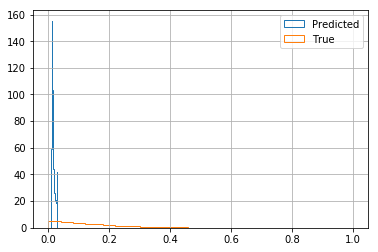

In [31]:
plt.hist(mass_predict, weights=weights_test, bins=50, histtype="step", normed=1, label="Predicted")
plt.hist(mass_test, weights=weights_test, bins=50, histtype="step", normed=1, label="True")

#plt.ylim(0, 5)
plt.legend()
plt.grid()
plt.show()
#doesnt change after adversrial training.. should get worse

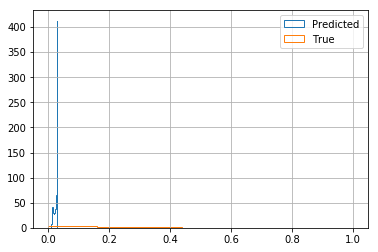

In [32]:
plt.hist(mass_predict[y_test==1], weights=weights_test[y_test==1], bins=50, histtype="step", normed=1, label="Predicted")
plt.hist(mass_test[y_test==1], weights=weights_test[y_test==1], bins=50, histtype="step", normed=1, label="True")

#plt.ylim(plt.titlelt.title("VBF Events")
plt.legend()
plt.grid()
plt.show()

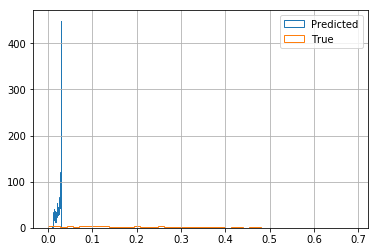

In [33]:
plt.hist(mass_predict_train[y_train==1], weights=weights_train[y_train==1], bins=50, histtype="step", normed=1, label="Predicted")
plt.hist(mass_train[y_train==1], weights=weights_train[y_train==1], bins=50, histtype="step", normed=1, label="True")

#plt.ylim(plt.titlelt.title("VBF Events")
plt.legend()
plt.grid()
plt.show()

In [34]:
# why cant it memorise? are there identical events? need to pca and project to 3d then see
# mass comparison.. maybe binned regression is better with tensorboard

In [35]:
y_pred_dc_train = D.predict(X_train).ravel()

In [36]:
#int_pred_test_sig = [weights_train[(y_train ==1) & (y_pred_train > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
#int_pred_test_bkg = [weights_train[(y_train ==0) & (y_pred_train > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

int_pred_dc_test_sig = [weights_test[(y_test ==1) & (y_pred_dc > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_dc_test_bkg = [weights_test[(y_test ==0) & (y_pred_dc > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

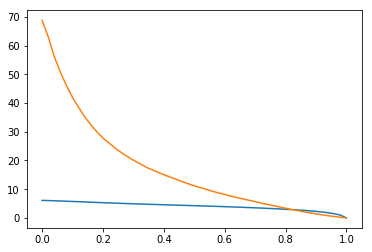

In [37]:
plt.plot(np.linspace(0,1,num=50),int_pred_dc_test_sig)
plt.plot(np.linspace(0,1,num=50),int_pred_dc_test_bkg)

In [38]:
from util_func import amsasimov
vamsasimov_dc = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_dc_test_sig,int_pred_dc_test_bkg)]
significance_dc = max(vamsasimov_dc)
threshold_dc = np.linspace(0,1,num=50)[ np.array(vamsasimov_dc).argmax() ]

In [ ]:
significance_dc, threshold_dc

In [ ]:
plt.plot(np.linspace(0,1,num=50),vamsasimov_dc)

In [ ]:
from util_func import compare_train_test
compare_train_test(y_pred_dc_train, y_train, y_pred_dc, y_test)

In [ ]:
def getGevMass(mass):
    return np.exp (mass * (mass_max - mass_min) + mass_min)
plt.hist(getGevMass(mass_test), weights=weights_test, bins=50, histtype="step", normed=1, range=(220, 2000), label="Preselection")
plt.hist(getGevMass(mass_test[y_pred_dc >= threshold_dc]), weights=weights_test[y_pred_dc >= threshold_dc], bins=50, histtype="step", normed=1, range=(220, 2000), label="Score > " + str(threshold_dc))

plt.title("Mass Distribution (s+b)")
#plt.ylim(0, 4)
plt.xlim(200, 1200)
plt.xlabel("mass GeV")
plt.legend()
plt.grid()
plt.show()

temp = np.zeros((len(mass_test),), dtype=[('mass',np.float64),('weight',np.float64),('NN_score',np.float64) ])
temp['mass'] = np.array(getGevMass(mass_test))
temp['weight'] = np.array(weights_test)
temp['NN_score'] = np.array(y_pred_dc)

from root_numpy import array2tree
tree_dc = array2tree(temp)

from ROOT import TEfficiency, TH1F
bins = 50
scoremin = temp['mass'].min()
scoremax = temp['mass'].max()
hpreselect_dc = TH1F("hpreselect_dc", "mass distribution before NN", bins, scoremin, scoremax)
hpreselect_dc.Sumw2()
hD = TH1F("hD", "mass distribution for D Score > " + str(threshold_dc), bins, scoremin, scoremax)
hD.Sumw2()
#tree.Project("hpreselect", "mass", "weight" ) #Tefficiency can;t do weights
tree_dc.Project("hpreselect_dc", "mass" )
#tree.Project("hNN", "mass", "weight*(NN_score>=" +str(threshold) + ")" )
tree_dc.Project("hD", "mass", "(NN_score>=" +str(threshold_dc) + ")" )

print TEfficiency.CheckConsistency(hD, hpreselect_dc)
pEff_dc = TEfficiency(hD, hpreselect_dc)

from ROOT import TCanvas
c_dc = TCanvas("dcCanvas","dc Canvas",800,350)
pEff_dc.SetTitle("Efficiency: Pre-selection vs Post D Selection;Mass (GeV) ;#epsilon")

pEff_dc.Draw("AP")
#ROOT.enableJSVis()
c_dc.Draw()

In [ ]:
(mass_predict !=0).sum()

# Again with adverserial training

In [ ]:
def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    ax1 = plt.subplot(311)   
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$", color="blue")
    plt.legend(loc="upper right")
    plt.grid()
    
    ax2 = plt.subplot(312, sharex=ax1) 
    values = np.array(losses["L_r"]) #/ lam
    plt.plot(range(len(values)), values, label=r"$\lambda L_r$", color="green")
    plt.legend(loc="upper right")
    plt.grid()
    
    ax3 = plt.subplot(313, sharex=ax1)
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.legend(loc="upper right")
    plt.grid()
    
    plt.show()

In [ ]:
losses = {"L_f": [], "L_r": [], "L_f - L_r": []}

In [ ]:
batch_size = 128
training_iterations = 201 #50
for i in range(training_iterations):
    #l = DRf.evaluate(X_test, [y_test, mass_test], sample_weight=[weights_test,weights_test], verbose=0)  
    l = DRf.evaluate(X_train, [y_train, mass_train], sample_weight=[weights_train,weights_train], verbose=0)  
    losses["L_f - L_r"].append(l[0][None][0])
    losses["L_f"].append(l[1][None][0]) # why none, 0? just do l[1]??
    losses["L_r"].append(-l[2][None][0]) # the - cancels the - in loss -lam
    print(losses["L_f"][-1], losses["L_r"][-1] / lam, losses["L_r"][-1])
    
    if i % 5 == 0:
        plot_losses(i, losses)

    # Fit D
    make_trainable(R, False)
    make_trainable(D, True)
    indices = np.random.permutation(len(X_train))[:batch_size]
    print "DRf"
    #use iloc
    ##DRf.train_on_batch(X_train[indices], [y_train[indices], mass_train[indices]], sample_weight=[weights_train[indices], weights_train[indices]])
    DRf.train_on_batch(X_train[indices], [y_train[indices], mass_train[indices]], sample_weight=[weights_train[indices], weights_train[indices]*y_train[indices]])
    #@TODO: Make explicite masking with weights, y_train mught become multiclass later
    
    # Fit R
    make_trainable(R, True)
    make_trainable(D, False)
    print "DfR"
    #masking background events
    DfR.fit(X_train, mass_train, batch_size=batch_size, sample_weight=weights_train*y_train, nb_epoch=1, verbose=1)
    ##DfR.fit(X_train, mass_train, batch_size=batch_size, sample_weight=weights_train, nb_epoch=1, verbose=1)
    #DfR.fit(X_train, mass_train, batch_size=batch_size, nb_epoch=1, verbose=1)
    #DfR.fit(X_train, mass_train, nb_epoch=1, verbose=1)
    #DfR.fit(X_train, mass_train, sample_weight=weights_train, nb_epoch=1, verbose=1)
    #@TODO: try grad reversal layer

In [ ]:
from sklearn.metrics import roc_auc_score
y_pred_dc = D.predict(X_test)
y_pred_dc = y_pred_dc.ravel()
roc_auc_score(y_test, y_pred_dc, sample_weight=weights_test)

plt.hist(y_pred_dc[mass_test<mass_test.mean()], weights=weights_test[mass_test<mass_test.mean()], bins=50, histtype="step", normed=1, label="Low")
plt.hist(y_pred_dc[mass_test>=mass_test.mean()], weights=weights_test[mass_test>=mass_test.mean()], bins=50, histtype="step", normed=1, label="High")

plt.legend()
plt.grid()
plt.show()

In [ ]:
from scipy.stats import pearsonr
corr = pearsonr(mass_test, y_pred_dc)
print "Unweighted correlation with mass is", corr

In [ ]:
y_pred_dc

In [ ]:
mass_predict = R.predict(X_test)

In [ ]:
DfR.evaluate(X_test, [mass_test], sample_weight=weights_test)

In [ ]:
plt.hist(mass_predict, weights=weights_test, bins=50, histtype="step", normed=1, label="Predicted")
plt.hist(mass_test, weights=weights_test, bins=50, histtype="step", normed=1, label="True")

#plt.ylim(0, 5)
plt.legend()
plt.grid()
plt.show()
#doesnt change after adversrial training.. should get worse

In [ ]:
y_pred_dc_train = D.predict(X_train).ravel()

In [ ]:
#int_pred_test_sig = [weights_train[(y_train ==1) & (y_pred_train > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
#int_pred_test_bkg = [weights_train[(y_train ==0) & (y_pred_train > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

int_pred_dc_test_sig = [weights_test[(y_test ==1) & (y_pred_dc > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_dc_test_bkg = [weights_test[(y_test ==0) & (y_pred_dc > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

In [ ]:
plt.plot(np.linspace(0,1,num=50),int_pred_dc_test_sig)
plt.plot(np.linspace(0,1,num=50),int_pred_dc_test_bkg)

In [ ]:
from util_func import amsasimov
vamsasimov_dc = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_dc_test_sig,int_pred_dc_test_bkg)]
significance_dc = max(vamsasimov_dc)
threshold_dc = np.linspace(0,1,num=50)[ np.array(vamsasimov_dc).argmax() ]

In [ ]:
significance_dc, threshold_dc

In [ ]:
plt.plot(np.linspace(0,1,num=50),vamsasimov_dc)

In [ ]:
from util_func import compare_train_test
compare_train_test(y_pred_dc_train, y_train, y_pred_dc, y_test)

In [ ]:
def getGevMass(mass):
    return np.exp (mass * (mass_max - mass_min) + mass_min)
plt.hist(getGevMass(mass_test), weights=weights_test, bins=50, histtype="step", normed=1, range=(220, 2000), label="Preselection")
plt.hist(getGevMass(mass_test[y_pred_dc >= threshold_dc]), weights=weights_test[y_pred_dc >= threshold_dc], bins=50, histtype="step", normed=1, range=(220, 2000), label="Score >= " + str(threshold_dc))
plt.hist(getGevMass(mass_test[y_pred_dc < threshold_dc]), weights=weights_test[y_pred_dc < threshold_dc], bins=50, histtype="step", normed=1, range=(220, 2000), label="Score < " + str(threshold_dc))

plt.title("Mass Distribution (s+b)")
#plt.ylim(0, 4)
plt.xlim(200, 1200)
plt.xlabel("mass GeV")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# But R looks at all events, not just the ones with high score so it tries to 
#also predict the mass of background. It shouldnt


In [ ]:
plt.hist2d(x=mass_test,y=y_pred_dc, weights=weights_test, bins=50, label="Preselection")
#plt.hist2d(x=getGevMass(mass_test),y=y_pred_dc, weights=weights_test, bins=50, normed=1, label="Preselection")
#plt.hist(getGevMass(mass_test[y_pred_dc >= threshold_dc]), weights=weights_test[y_pred_dc >= threshold_dc], bins=50, histtype="step", normed=1, range=(220, 2000), label="Score >= " + str(threshold_dc))
#plt.hist(getGevMass(mass_test[y_pred_dc < threshold_dc]), weights=weights_test[y_pred_dc < threshold_dc], bins=50, histtype="step", normed=1, range=(220, 2000), label="Score < " + str(threshold_dc))

plt.title("Score vs Mass of all Events")
#plt.ylim(0, 4)
#plt.xlim(200, 1200)
plt.xlabel("mass GeV")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.hist2d(x=mass_test[y_pred_dc >= threshold_dc],y=y_pred_dc[y_pred_dc >= threshold_dc], weights=weights_test[y_pred_dc >= threshold_dc], bins=50, label="Score >= " + str(threshold_dc))
#plt.hist(getGevMass(mass_test[y_pred_dc >= threshold_dc]), weights=weights_test[y_pred_dc >= threshold_dc], bins=50, histtype="step", normed=1, range=(220, 2000), label="Score >= " + str(threshold_dc))
#plt.hist(getGevMass(mass_test[y_pred_dc < threshold_dc]), weights=weights_test[y_pred_dc < threshold_dc], bins=50, histtype="step", normed=1, range=(220, 2000), label="Score < " + str(threshold_dc))

plt.title("Score vs Mass of Score >= " + str(threshold_dc)+" Events")
#plt.ylim(0, 4)
#plt.xlim(200, 1200)
plt.xlabel("mass GeV")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.hist2d(x=mass_test[y_test ==1],y=y_pred_dc[y_test ==1], weights=weights_test[y_test ==1], bins=50, label="True VBF Events")
#plt.hist(getGevMass(mass_test[y_pred_dc >= threshold_dc]), weights=weights_test[y_pred_dc >= threshold_dc], bins=50, histtype="step", normed=1, range=(220, 2000), label="Score >= " + str(threshold_dc))
#plt.hist(getGevMass(mass_test[y_pred_dc < threshold_dc]), weights=weights_test[y_pred_dc < threshold_dc], bins=50, histtype="step", normed=1, range=(220, 2000), label="Score < " + str(threshold_dc))

plt.title("Score vs Mass of Score >= " + str(threshold_dc)+" Events")
#plt.ylim(0, 4)
#plt.xlim(200, 1200)
plt.xlabel("mass GeV")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.hist2d(x=mass_test[y_pred_dc < threshold_dc],y=y_pred_dc[y_pred_dc < threshold_dc], weights=weights_test[y_pred_dc < threshold_dc], bins=50, label="Score < " + str(threshold_dc))
#plt.hist(getGevMass(mass_test[y_pred_dc >= threshold_dc]), weights=weights_test[y_pred_dc >= threshold_dc], bins=50, histtype="step", normed=1, range=(220, 2000), label="Score >= " + str(threshold_dc))
#plt.hist(getGevMass(mass_test[y_pred_dc < threshold_dc]), weights=weights_test[y_pred_dc < threshold_dc], bins=50, histtype="step", normed=1, range=(220, 2000), label="Score < " + str(threshold_dc))

plt.title("Score vs Mass of Score < " + str(threshold_dc)+" Events")
#plt.ylim(0, 4)
#plt.xlim(200, 1200)
plt.xlabel("mass GeV")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

In [ ]:
temp = np.zeros((len(mass_test),), dtype=[('mass',np.float64),('weight',np.float64),('NN_score',np.float64) ])
temp['mass'] = np.array(getGevMass(mass_test))
temp['weight'] = np.array(weights_test)
temp['NN_score'] = np.array(y_pred_dc)

from root_numpy import array2tree
tree_dc = array2tree(temp)

from ROOT import TEfficiency, TH1F
bins = 50
scoremin = temp['mass'].min()
scoremax = temp['mass'].max()
hpreselect_dc = TH1F("hpreselect_dc", "mass distribution before NN", bins, scoremin, scoremax)
hpreselect_dc.Sumw2()
hD = TH1F("hD", "mass distribution for D Score > " + str(threshold_dc), bins, scoremin, scoremax)
hD.Sumw2()
#tree.Project("hpreselect", "mass", "weight" ) #Tefficiency can;t do weights
tree_dc.Project("hpreselect_dc", "mass" )
#tree.Project("hNN", "mass", "weight*(NN_score>=" +str(threshold) + ")" )
tree_dc.Project("hD", "mass", "(NN_score>=" +str(threshold_dc) + ")" )

print TEfficiency.CheckConsistency(hD, hpreselect_dc)
pEff_dc = TEfficiency(hD, hpreselect_dc)

from ROOT import TCanvas
c_dc = TCanvas("dcCanvas","dc Canvas",800,350)
pEff_dc.SetTitle("Efficiency: Pre-selection vs Post D Selection;Mass (GeV) ;#epsilon")

In [ ]:
pEff_dc.Draw("AP")
#ROOT.enableJSVis()
c_dc.Draw()

In [ ]:
(mass_predict !=0).sum()

In [ ]:
# Tensorboard : PCA and see if its impossible to even memorize mass, identical events diff mass
# find out why nan if I use indices but not train_test_split [because .iloc, fix]
# try to just make a NN map 1 to 2, 2 to 6, 3 to 9 memorise it

#: inject mass correlation and see if R learns anything at all. Find the elephant
# R is sometimes learning somtimes not.. why.. reproducible problem?
# the D without adverserial training is asmost same as after adverserial




# sometimes training R gives 0 for every event... why. not reproducible?
# why is the loss look decreasing further on pivot training, its not actually cuz auc is worse
#@TODO: Compare AUC/significance with qq, without qq

In [ ]:
# @Victor:
# pivot not working well
# V: Try to overfit on 100 samples: find elephant problems
# regression activation, loss function?
# V: Its okay trial and error | andreas did classification
# loss of r is changing at a lower level, maybe subtract off the first loss?
# V: maybe
# grad reversal layer
# V: simultaneous could be better
# why is the loss look decreasing further on pivot training, its not actually cuz auc is worse
# V: Maybe you need to let pre-training converge

!pip2 install jupyter_contrib_nbextensions

In [ ]:
#Ams loss function: celver way to impliment, if else wont work: like makeing soft cuts
# how close to 0, how close to 1
